## 11.7

 Code up the EM algorithm for a Gaussian mixture model.

In [102]:
import numpy as np
from scipy.stats import multivariate_normal as multinorm
from scipy.optimize import minimize
from sklearn.datasets import load_iris
from matplotlib import pyplot as plt

In [103]:
def EM(X, K, theta = None, max_iter = 100, tol= 1e-3):
    n,d = X.shape
    
    def to_theta(ws,mus,sigmas):
        return np.hstack((ws.flatten(),mus.flatten(),sigmas.flatten()))

    def to_wms(theta):
        return theta[:K],theta[K:K + K * d].reshape(K,d),theta[-K * d * d:].reshape(K,d,d)
    
    if theta != None:        
        ws,mus,sigmas = to_wms(theta)
    
    else:
        ws = np.array([1/K]*K)
        mus =  np.random.randn(K,d) * X.var(axis=0) + X.mean(axis=0)
        sigmas = np.array([np.eye(d)]*K)
        
    for _ in range(max_iter):
        # Calculate q_i(y=k) matrix
        q_ik = np.array([[multinorm.pdf(xi, mean=mus[y],cov=sigmas[y]) * ws[y] for y in range(K)] for xi in X])

        # now make the rows of q_ik sum to one
        q_ik = (q_ik.T / q_ik.T.sum(axis=0)).T
        
        next_ws = q_ik.sum(axis=0)/n
        next_mus = np.array([sum([q_ik[i,k] * X[i] for i in range(n)])/sum(q_ik[:,k]) for k in range(K)])
        next_sigmas = np.array([sum([q_ik[i,k] * (X[i] - next_mus[k]) @ (X[i] - next_mus[k]).T for i in range(n)])/q_ik[:,k].sum() for k in range(K)])
        
        # end condition
        if np.linalg.norm(next_ws - ws) < tol and np.linalg.norm(next_mus - mus) < tol and np.linalg.norm(next_sigmas - sigmas) < tol:
            break
        ws = next_ws
        mus = next_mus
        sigmas = next_sigmas
    
    return next_ws,next_mus,next_sigmas

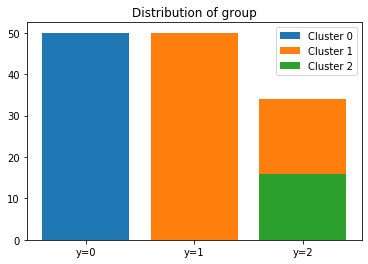

In [106]:
iris = load_iris()
X = iris.data
y = iris.target

ws, mus, sigmas = EM(X,3)
probs = np.array([[multivariate_normal.pdf(xi,mean=mus[y],cov=sigmas[y]) for y in range(3)] for xi in X])
categories = np.argmax(probs,axis=1)

zeros = y == 0
ones = y == 1
twos = y == 2

ps = [plt.bar([0,1,2], np.array([sum(categories[m] == i) for m in [zeros, ones, twos]])) for i in range(3)]
plt.legend((ps[0],ps[1],ps[2]),("Cluster 0","Cluster 1","Cluster 2"))
plt.title("Distribution of group")
plt.xticks([0,1,2],("y=0","y=1","y=2"))
plt.show()

It appears that the two overlapping flower types are not perfectly clustered, but the outlying cluster perfectly describes the more distinct flower type.